### Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torch import nn
from torch import optim
import pandas as pd
import torchvision
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torchsummary import summary
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

In [2]:
# set up the device
if torch.cuda.is_available():
    device = torch.device("cuda")          
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# avoid CUDA errors
CUDA_LAUNCH_BLOCKING=1

In [4]:
# empty cache
torch.cuda.empty_cache()

### Data Processing - Monet

#### Define the training dataset and processing functions

In [5]:
class Monet(Dataset):
    # initializaion method
    def __init__(self, dir_path, transform=None):
        self.dir_path = dir_path
        self.transform = transform
        # sort the names of all images and assign them
        self.filenames = sorted([f for f in os.listdir(dir_path) 
                                 if os.path.isfile(os.path.join(dir_path, f))])

    def __len__(self):
        # return the number of images in the dataset
        return len(self.filenames)
    
    # method to get item by index
    def __getitem__(self, idx):
        # create the path for the image
        img_path = os.path.join(self.dir_path, self.filenames[idx])
        try:
            # open the image if no error and convert it to RGB format
            img = Image.open(img_path).convert('RGB')
        # catch possible exceptions
        except (FileNotFoundError, PermissionError, PIL.UnidentifiedImageError) as e:
            print(f"Error opening image {img_path}: {e}")
            return None
        # check if the transform accessible
        if self.transform:
            # apply transform
            img = self.transform(img)

        return img

In [6]:
# customize image size
img_size= 64

# define transform
transform = transforms.Compose([
    # resize the image
    transforms.Resize(img_size),
    # convert to tensor type
    transforms.ToTensor(),
    # normalize to [-1, 1]
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

In [7]:
# create our traning dataset
dir_path = 'Monet'
dataset = Monet(dir_path, transform=transform)

In [8]:
# customize batch size
batch_size = 32

# define dataloader
dataloader = DataLoader(
    dataset,
    batch_size = batch_size,
    shuffle = True
)

In [9]:
# function to display (or save) an image, either for the image in dataset or the generated fake image
def show_image(image, epoch=None, iteration=None, loss=None, save=False):
    plt.figure(figsize = (4, 4))
    
    # convert tensor to a numpy array for plot
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).detach().numpy()

    # rescale image from [-1, 1] to [0,1]
    if np.min(image) < 0:
        image = (image + 1) / 2

    plt.imshow(image)
    
    # save option
    if save and epoch is not None and iteration is not None and loss is not None:
        filename = f'generated_img_epoch_{epoch}_iteration_{iteration}_loss_{loss:.3f}.png'
        plt.savefig(filename)
        
    plt.show()

In [10]:
# function to display a batch, either in the dataset or the generated fake batch
def show_batch(images_list, epoch=None, iteration=None, loss=None, save=False):
    fig = plt.figure(figsize = (14, 14))
    # define how many image space will be displayed
    lenth = int(np.ceil(np.sqrt(len(images_list))))
    shape = (lenth, lenth)
    
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.05)

    # convert tensor to a numpy array for plot
    if isinstance(images_list, torch.Tensor):
        images_list = images_list.permute(0, 2, 3, 1).detach().numpy()

    # rescale image from [-1, 1] to [0,1]
    if np.min(images_list) < 0:
        images_list = (images_list + 1) / 2
    
    # plot grids
    for ax, image in zip(grid, images_list):
        ax.imshow(image)

    # save option
    if save and epoch is not None and iteration is not None and loss is not None:
        filename = f'generated_batch_epoch_{epoch}_iteration_{iteration}_loss_{loss:.3f}.png'
        plt.savefig(filename)

    plt.show()

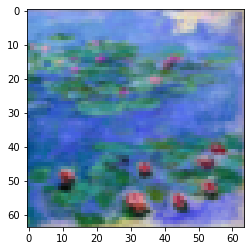

In [11]:
sample_image = next(iter(dataloader))[0]
show_image(sample_image)

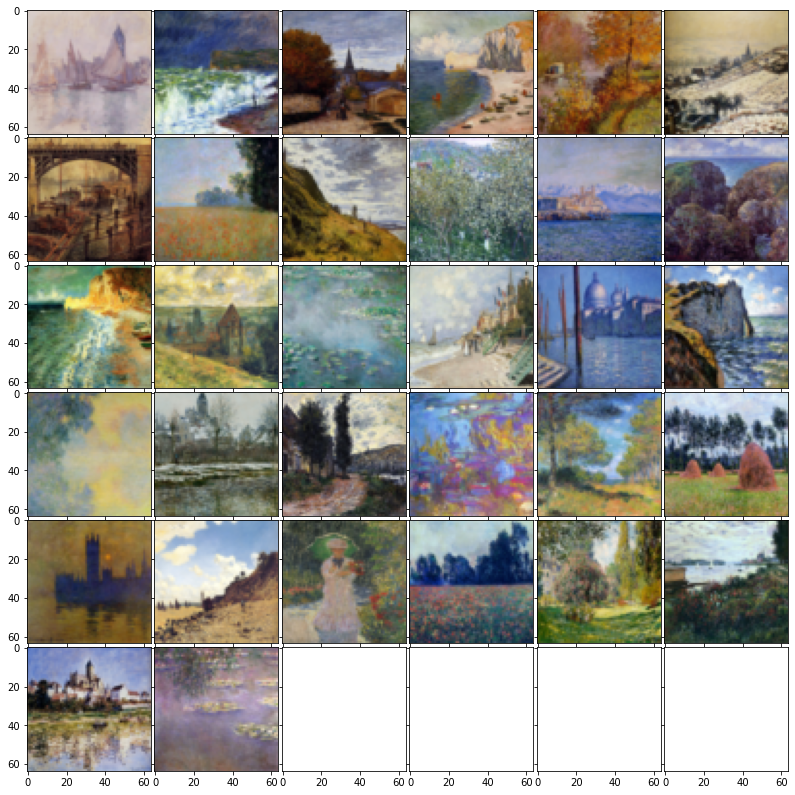

In [12]:
sample_batch = next(iter(dataloader))
show_batch(sample_batch)

### Data Processing - CIFAR-10

In [13]:
# option 1: selected number of images
# result: model corrupt after 168 epochs
# custom image size
img_size = 64
transform = transforms.Compose(
    # resize the image
    [transforms.Resize(img_size),
     # convert to tensor type
     transforms.ToTensor(),
     # Normalize the image
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32
dataset2 = torchvision.datasets.CIFAR10(root='./data', download=True, train=True,
                                       transform=transform)
# select the interested class
target_class= 'deer'
# select the first 1369 images to match the number of images in the monet dataset
num_images = 1369
filtered_data = []
count = 0
# filter out target data from the original data
for img, label in dataset2:
    if dataset2.classes[label] == target_class:
        filtered_data.append(img)
        count += 1
    if count >= num_images:
        break

dataloader2 = DataLoader(filtered_data, batch_size=batch_size,
                                          shuffle=True)
print(len(dataloader2))

Files already downloaded and verified
43


In [40]:
# if want to use more data, use this option
# custom image size
img_size = 64
transform = transforms.Compose(
    # resize the image
    [transforms.Resize(img_size),
     # convert to tensor type
     transforms.ToTensor(),
     # Normalize the image
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32
dataset2 = torchvision.datasets.CIFAR10(root='./data', download=True, train=True,
                                       transform=transform)
# select the interested class
target_class= 'deer'
filtered_data = []
count = 0
# filter out target data from the original data
for img, label in dataset2:
    if dataset2.classes[label] == target_class:
        filtered_data.append(img)
        count += 1
dataloader2 = DataLoader(filtered_data, batch_size=batch_size,
                                          shuffle=True)
print(len(dataloader2))

Files already downloaded and verified
157


In [75]:
next(iter(dataloader2))[0].shape

torch.Size([3, 64, 64])

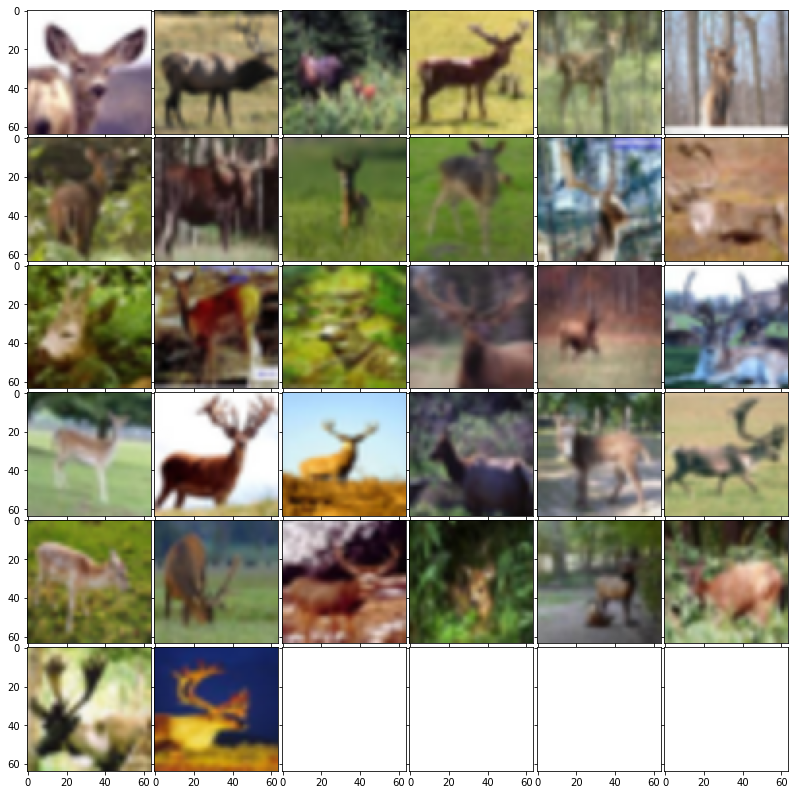

In [76]:
sample_batch = next(iter(dataloader2))
show_batch(sample_batch)

### Model Construction

This class is for the discriminator component of our DCGAN, structured as a CNN. It classifies images between real(=1) or fake(=0). <br>
It includes five convolutional layers, each uses a 4x4 kernel with different strides and paddings, follwed by batch normalization, LeakyReLU, and the last layer ends with a flatten and a signoid function.

In [138]:
class Discriminator(nn.Module):
    # constructor method
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # input: 3 channels x (64x64)
            # output: 64 channels x (32x32)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output: 128 channels x (16x16)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # output: 256 channels x (8x8)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # output: 512 channels x (4x4)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # output: 1 channels x (1x1)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # Output: N x 1 x 1 x 1
            
            # flatten to single dimension
            nn.Flatten(),
            # output probability
            nn.Sigmoid()
        )
    # forward mathod
    def forward(self, input):
        # take input to model
        return self.model(input)

In [139]:
# initialize the discriminator and move the params to gpu
discriminator = Discriminator().to(device)
# summary the disciminator
summary(discriminator, (3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Flatten-13                    [-1, 1]               0
          Sigmoid-14                   

In [140]:
class Generator(nn.Module):
    # constructor method with noise dimension initialized
    def __init__(self, noise_dim=128):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # input: noise_dim channels x (1x1)
            # output: 512 channels x (4x4)
            nn.ConvTranspose2d(noise_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            # output: 256 channels x (8x8)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # output: 128 channels x (16x16)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # output: 64 channels x (32x32)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # output: 3 channels x (64x64)
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            
            # resize to [-1,1]
            nn.Tanh()
        )
    
    # forward method that takes noise as input
    def forward(self, noise):
        # reshape
        noise = noise.view(-1, noise_dim, 1, 1)
        return self.model(noise)

In [141]:
# define the dimension of the noise
noise_dim = 128
# initialize the generator and move the params to gpu
generator = Generator(noise_dim=noise_dim).to(device)
# summary the generator
summary(generator, (noise_dim, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

### Training - Monet

In [153]:
# set Binary Cross Entropy as loss function
criterion = nn.BCELoss()
# learning rate
lr = 0.0002
# important param in Adam to tune
beta1 = 0.5

# define optimizers for G and D
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

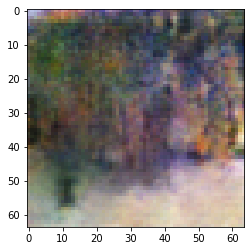

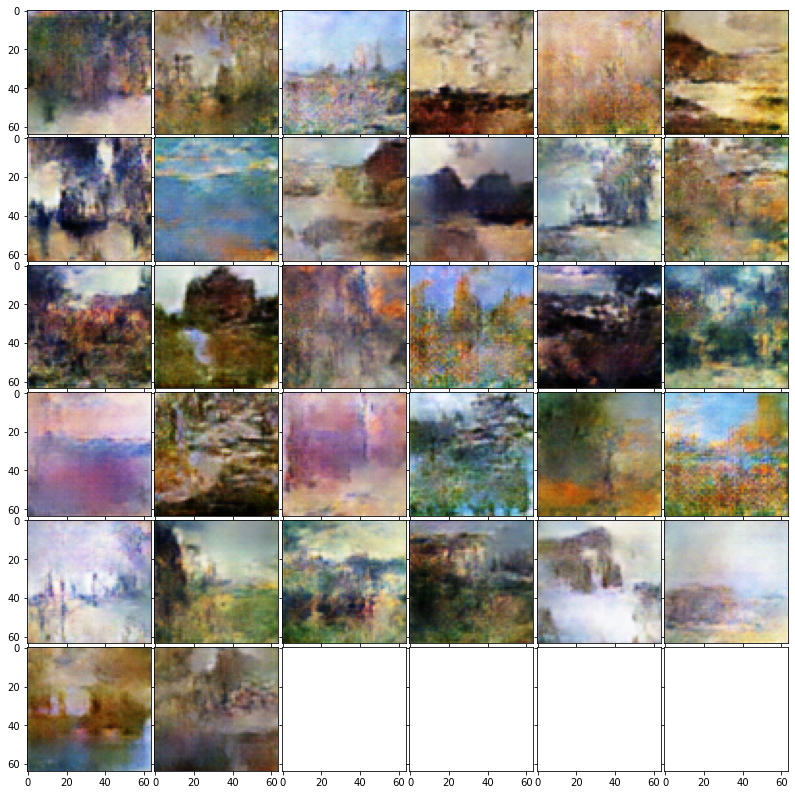

In [154]:
num_epochs = 200
real_label = 1.
fake_label = 0.
G_losses = []
D_losses = []
lowest_loss = float('inf')
best_fake = None
results = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        # zero out the gradient
        discriminator.zero_grad()
        real_data = data.to(device)
        batch_size = real_data.size(0)
        
        # real label tensor
        label = torch.full((batch_size,), real_label, dtype=real_data.dtype, device=device)
        # pass real label to D
        output = discriminator(real_data).view(-1)
        
        D_real_loss = criterion(output, label)
        # backpropagation 
        D_real_loss.backward()
        
        # generate random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        fake = generator(noise)
        
        # fake label tensor
        label.fill_(fake_label)
        # pass fake label to D
        output = discriminator(fake.detach()).view(-1)
        
        D_fake_loss = criterion(output, label)
        D_fake_loss.backward()
        
        D_loss = D_real_loss + D_fake_loss
        D_losses.append(D_loss.item())
        
        # update D's weights
        optimizerD.step()
        
        # zero out the gradient
        generator.zero_grad()
        
        label.fill_(real_label)  
        output = discriminator(fake).view(-1)
        
        G_loss = criterion(output, label)
        G_losses.append(G_loss.item())
        G_loss.backward()
        
        # update G's weights
        optimizerG.step()
        
        current_loss = G_losses[-1]
        if current_loss < lowest_loss:
            lowest_loss = current_loss
            # save the best fake images
            best_fake = fake.detach().cpu()
        
        # save loss infomation
        results.append({
            'Epoch': epoch,
            'Batch': i,
            'Loss_D': D_loss.item(),
            'Loss_G': G_loss.item()
        })
        
df = pd.DataFrame(results)
df.to_csv('training_data.csv', index=False)

show_image(best_fake[0], num_epochs, i, loss=lowest_loss, save=True)  
show_batch(best_fake, num_epochs, i, loss=lowest_loss, save=True) 

In [155]:
# save best G and D
torch.save(generator.state_dict(), "generator.pt")
torch.save(discriminator.state_dict(), "discriminator.pt")

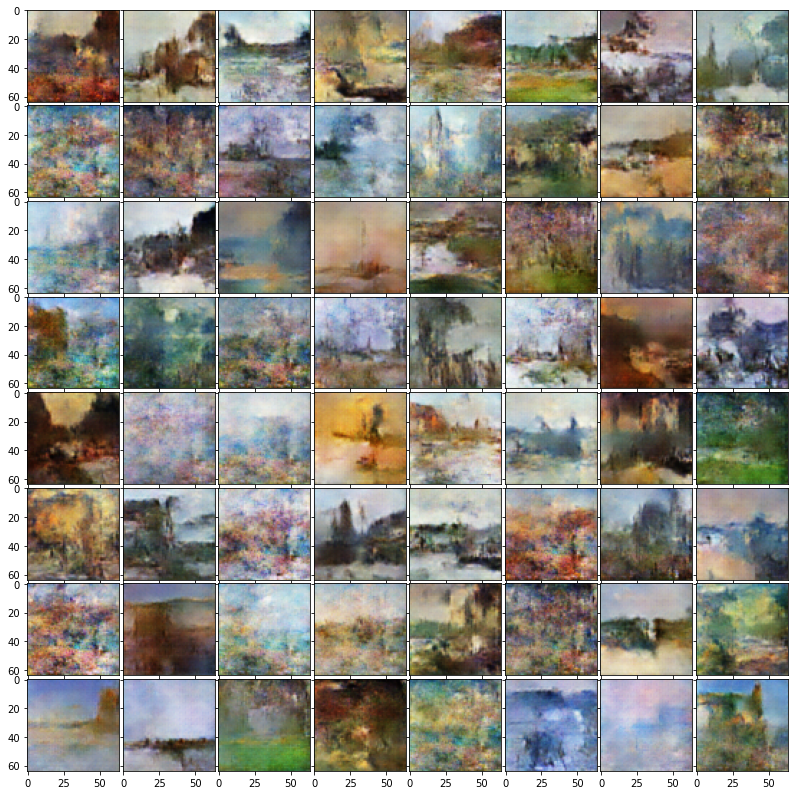

In [156]:
# using best G, generate sample images
num_images = 64
noise = torch.randn(num_images, noise_dim, 1, 1, device=device)
fake_batch = generator(noise).detach().cpu()
show_batch(fake_batch)

In [157]:
# show training loss details
df

Epoch  Batch    Loss_D     Loss_G
0         0      0  0.114920  11.523148
1         0      1  0.664029   6.005211
2         0      2  0.166787   4.276557
3         0      3  0.353194   7.500734
4         0      4  0.042311   8.033049
...     ...    ...       ...        ...
8595    199     38  0.061748   8.444265
8596    199     39  0.010787   8.600741
8597    199     40  0.038898   8.910112
8598    199     41  0.010509   8.888699
8599    199     42  0.056113   7.310739

[8600 rows x 4 columns]

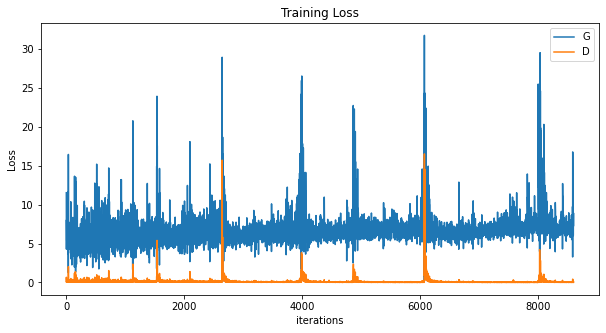

In [158]:
# Print Loss
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Training - CIFAR-10

In [119]:
# initialize G and D
discriminator2 = Discriminator().to(device)
noise_dim2 = 128
generator2 = Generator(noise_dim=noise_dim2).to(device)

In [120]:
criterion2 = nn.BCELoss()
lr2 = 0.0004
beta12 = 0.8

optimizerD2 = torch.optim.Adam(discriminator2.parameters(), lr=lr2, betas=(beta12, 0.999))
optimizerG2 = torch.optim.Adam(generator2.parameters(), lr=lr2, betas=(beta12, 0.999))

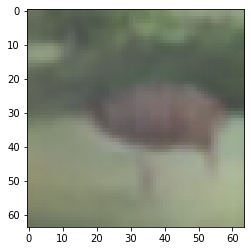

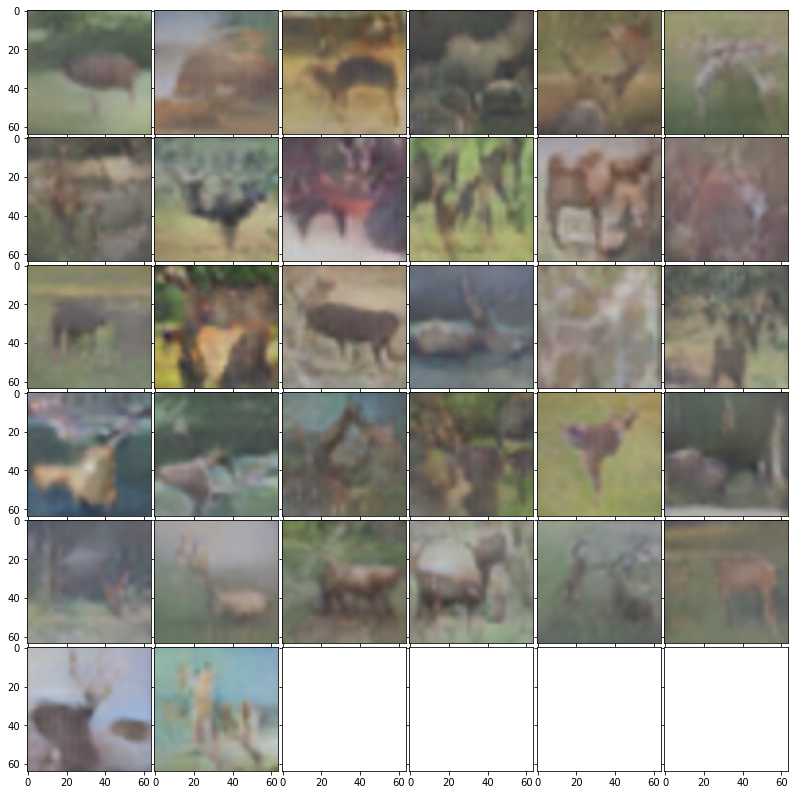

In [121]:
num_epochs2 = 200
real_label2 = 1.
fake_label2 = 0.
G_losses2 = []
D_losses2 = []
lowest_loss2 = float('inf')
best_fake2 = None
results2 = []

for epoch in range(num_epochs2):
    for i, data2 in enumerate(dataloader2, 0):
        
        # zero out the gradient
        discriminator2.zero_grad()
        real_data2 = data2.to(device)
        batch_size2 = real_data2.size(0)
        
        # real label tensor
        label2 = torch.full((batch_size2,), real_label2, dtype=real_data2.dtype, device=device)
        # pass real label to D
        output2 = discriminator2(real_data2).view(-1)
        
        D_real_loss2 = criterion2(output2, label2)
        # backpropagation 
        D_real_loss2.backward()
        
        # generate random noise
        noise2 = torch.randn(batch_size2, noise_dim2, 1, 1, device=device)
        fake2 = generator2(noise2)
        
        # fake label tensor
        label2.fill_(fake_label2)
        # pass fake label to D
        output2 = discriminator2(fake2.detach()).view(-1)
        
        D_fake_loss2 = criterion2(output2, label2)
        D_fake_loss2.backward()
        
        D_loss2 = D_real_loss2 + D_fake_loss2
        D_losses2.append(D_loss2.item())
        
        # update D's weights
        optimizerD2.step()
        
        # zero out the gradient
        generator2.zero_grad()
        
        label2.fill_(real_label2)  
        output2 = discriminator2(fake2).view(-1)
        
        G_loss2 = criterion2(output2, label2)
        G_losses2.append(G_loss2.item())
        G_loss2.backward()
        
        # update G's weights
        optimizerG2.step()
        
        current_loss2 = G_losses2[-1]
        if current_loss2 < lowest_loss2:
            lowest_loss2 = current_loss2
            # save the best fake images
            best_fake2 = fake2.detach().cpu()
        
        # save loss infomation
        results2.append({
            'Epoch': epoch,
            'Batch': i,
            'Loss_D': D_loss2.item(),
            'Loss_G': G_loss2.item()
        })
        
df2 = pd.DataFrame(results2)
df2.to_csv('training_data2.csv', index=False)

show_image(best_fake2[0], num_epochs2, i, loss=lowest_loss2, save=True)  
show_batch(best_fake2, num_epochs2, i, loss=lowest_loss2, save=True) 

In [122]:
torch.save(generator2.state_dict(), "generator2.pt")
torch.save(discriminator2.state_dict(), "discriminator2.pt")

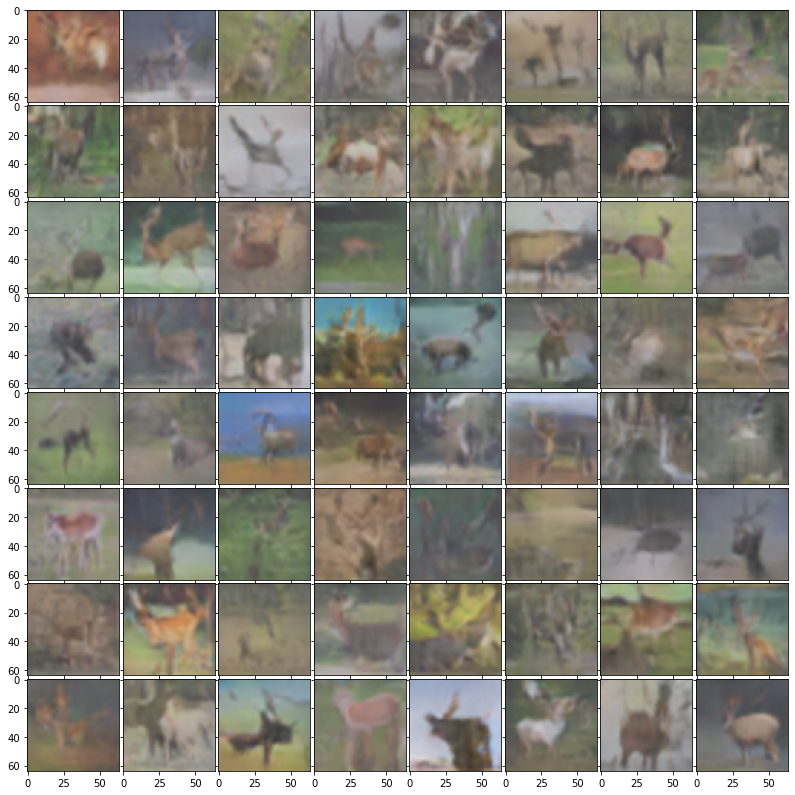

In [123]:
num_images = 64
noise = torch.randn(num_images, noise_dim, 1, 1, device=device)
fake_batch2 = generator2(noise).detach().cpu()
show_batch(fake_batch2)

In [124]:
df2

Epoch  Batch    Loss_D    Loss_G
0          0      0  1.360671  6.681531
1          0      1  1.563845  7.081223
2          0      2  1.144103  7.389934
3          0      3  1.175888  7.827163
4          0      4  0.730773  9.468487
...      ...    ...       ...       ...
31395    199    152  0.090004  5.792642
31396    199    153  0.078820  5.984041
31397    199    154  0.146543  7.148913
31398    199    155  0.102755  6.940903
31399    199    156  0.022617  7.768441

[31400 rows x 4 columns]

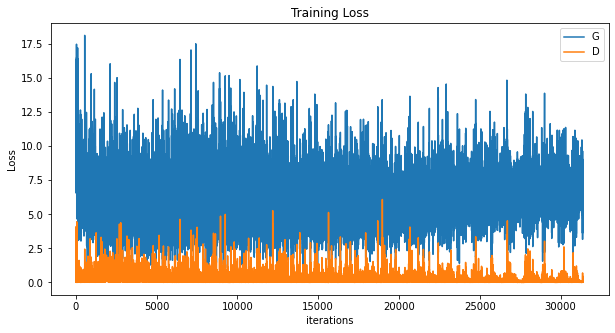

In [125]:
# print Loss
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(G_losses2,label="G")
plt.plot(D_losses2,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluation

In [150]:
import math
import sys
import tensorflow as tf
import urllib.request
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray
from torchvision.models import resnet50
from torch.nn.functional import softmax

In [151]:
# code adapted from https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/
class InceptionScore:
    def __init__(self):
        # use VGG16 as the inception model, since inception V3 input size is 299, which
        # would result in a bad score for our image (64)
        self.model = models.vgg16(pretrained=True).cuda()
        # set VGG16 model to evaluation mode
        self.model.eval()
        # transform image to match the required size and type
        self.up = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor()])

    def get_probabilities(self, imgs):
        probs = []
        for img in imgs:
            # move to cpu for transformation and move back to gpu
            img = self.up(img.cpu()).cuda()
            with torch.no_grad():
                # add one more dimension and combine them as a Variable
                img_var = Variable(img.unsqueeze(0))
                # get logits for prob
                logits = self.model(img_var)
                # get prob
                probs.append(softmax(logits, dim=1).data.cpu().numpy())
        
        return np.concatenate(probs, axis=0)
    
    # take a batch of generated images and split them to evaluate
    def get_score(self, images, splits=10):
        scores = []
        n = len(images)
        # method to split the images
        for i in range(splits):
            start = i * n // splits
            if (i != splits - 1):
                end = (i + 1) * n // splits
            else:
                end = n
            target = images[start:end, :]
            # calculate prob of each split
            prob = self.get_probabilities(target).mean(axis=0)
            # calculate score of each split, which is the entropy of the probability
            scores.append(entropy(prob))
            
        return np.exp(np.mean(scores)), np.exp(np.std(scores))




In [160]:
# lowest inception score is 1.0 in this case, highest inception score is the # of classes (1000) of the pre-trained inception model
# Monet Dataset
inceptor = InceptionScore()
mean_score, std_score = inceptor.get_score(fake_batch)

print(f"Mean Inception Score: {mean_score}, Standard Deviation: {std_score}")


Mean Inception Score: 358.570556640625, Standard Deviation: 1.1526408195495605


In [129]:
# CIFAR-10 deer Dataset
inceptor = InceptionScore()
mean_score, std_score = inceptor.get_score(fake_batch2)

print(f"Mean Inception Score: {mean_score}, Standard Deviation: {std_score}")


Mean Inception Score: 254.05844116210938, Standard Deviation: 1.2268973588943481
